In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

### Loading dataframe used in modeling 

In [2]:
city = 'boston'

In [7]:
# load data
df = pd.read_csv('../data/{}/processed/seg_with_predicted.csv'.format(city),
                dtype={'segment_id':'str'})
# load model
m = pickle.load(open('../data/{}/processed/model.pkl'.format(city), 'rb'))

In [8]:
# testing intervention effectchanging speed: speed reduction
features = m.get_booster().feature_names
speed_features = [f for f in features if f.find('SPEED')!=-1]
speed_df = df.copy(deep=True)
speed_df.loc[speed_df.SPEEDLIMIT>20, speed_features] = 0
speed_df.loc[speed_df.SPEEDLIMIT>20, 'SPEEDLIMIT20'] = 1
preds = m.predict_proba(df[features])[::,1]
preds_speed = m.predict_proba(speed_df[features])[::,1]
preds_df = pd.DataFrame([preds, preds_speed]).T
speed_df['predicted'] = preds_speed
speed_df.to_json('../data/boston/processed/seg_w_predicted_speed20.json', orient='records')

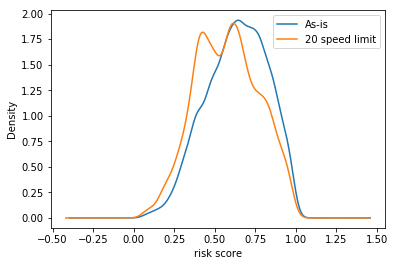

In [9]:
changed = preds_df.diff(axis=1).iloc[:,1]!=0
p = preds_df[changed].plot(kind='kde')
p.set_xlabel('risk score')
p.legend(labels=['As-is','20 speed limit'])

In [17]:
import geopandas as gpd

In [18]:
streets = gpd.read_file('../data/boston/processed/maps/inter_and_non_int.geojson')

Text(0.5,0,'risk score')

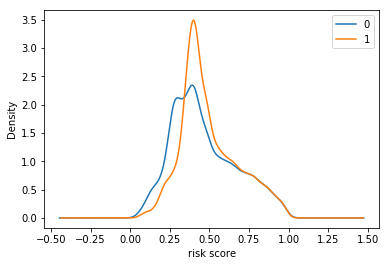

In [47]:
# change no jams to some jams
jam_feats = [x for x in features if x.find('jam')>-1]
jam_df = df.copy(deep=True)
# has no jams
no_jams = jam_df.jam0==1
jam_df.loc[no_jams, 'jam0'] = 0
jam_df.loc[no_jams, 'jam1'] = 1
jam_df.loc[no_jams, 'log_jam_pct'] = np.log(10)
preds_jam = m.predict_proba(jam_df[features])[::,1]
preds_df = pd.DataFrame([preds, preds_jam]).T
p = preds_df.plot(kind='kde')
p.set_xlabel('risk score')

In [65]:
# join to get street names
id_preds = pd.concat([df['segment_id'], preds_df], axis=1)
id_preds.columns = ['segment_id', 'before', 'after']
#id_preds = id_preds.merge(streets, left_on='segment_id', right_on='id')
id_preds['diff'] = id_preds.after - id_preds.before
id_preds.to_csv('../data/boston/processed/jam_diff.csv')